In [1]:
import ee 
import folium
import geehydro
from datetime import datetime as dt
from IPython.display import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Autheticate and then initialize the session using your credentials
#ee.Authenticate()
ee.Initialize()

In [532]:
def return_time_series_collection(start_time='2000-01-01',end_time='2018-01-01',
                       data_source='LANDSAT/LC8_L1T_TOA',
                       cloud_cover=5,
                       input_bands=['B4','B5','B6'],
                       roi = [5.727906, 51.993435,
                                 5.588144, 51.944356]):
    '''
    Time: yyyy-mm-dd
    roi: Region-of-interest
    
    '''
    
    ## Define your image collection 
    collection = ee.ImageCollection(data_source)
    
    ## Define time range and filter the data
    collection_time = collection.filterDate(start_time, end_time) #YYYY-MM-DD
    
    x0,y0,x1,y1 = roi
    
    ROI = ee.Geometry.Rectangle([x0,y0,
                                 x1,y1])
    
    
    
    #collection_time = collection_time.filter(ee.Filter.eq('WRS_PATH', 198))
    #collection_time = collection_time.filter(ee.Filter.eq('WRS_ROW', 24))
    
    # Filter by a specific region
    filterRegion = collection_time.filterBounds(ROI)
    
    ## Select imagery with less then 5% of image covered by clouds
    clouds = filterRegion.filter(ee.Filter.lt('CLOUD_COVER', cloud_cover))
    
    ## Select bands
    bands = clouds.select(input_bands)
    
    eeCollection = bands
    
    collectionList = bands.toList(bands.size()) # Converts the image collection to a list accessible via index
    collectionSize = collectionList.size().getInfo()
    
    # Get the information about the dates of this collection
    collectionDates = [ee.Image(collectionList.get(indx)).getInfo()['properties']['DATE_ACQUIRED'] for indx in range(collectionSize)]
    
    
    return collectionSize,collectionList,collectionDates,eeCollection


def normalize(data):
    '''
    Normalize the data from 0->1
    '''
    
    norm = (data-data.min())/(data.max()-data.min())
    
    return norm

def convert_image_to_numpy(image,
                           roi=[5.727906, 51.993435,
                                5.588144, 51.944356],
                           input_bands=['B4','B5','B6'],
                          normalized=True):
    '''
    Converts a single image in the collection List to a numpy array
    
    
    This only works for smaller satellite image regions
    
    '''
    
    
    #image = ee.Image(collectionList.get(indx))
    ROI = ee.Geometry.Rectangle(roi)
    
    band_arrs = image.sampleRectangle(region=ROI)
    #band_arrs = image.stratifiedSample(region=ROI)
    
    img_arrays = [ np.array(band_arrs.get(band).getInfo()) for band in input_bands]
    
    # Rescale the arrays
    if(normalized==True):
        img_arrays = [normalize(img_array) for img_array in img_arrays]
    
    img_arrays = [np.expand_dims(img_array, 2) for img_array in img_arrays]
    rgb_img = np.concatenate(img_arrays, 2)
    
    
    return rgb_img


def train_Kmeans_classifier(img,K,roi):
    '''
    This simple function trains a K-means classifier on an image
    '''
    
    input = ee.Image(img)
    
    ROI = ee.Geometry.Rectangle(roi)
    
    # Make the training dataset.
    training = input.sample(**{
        'region': ROI,
        'scale': 30,
        'numPixels': 5000
    })

    # Instantiate the clusterer and train it.
    clusterer = ee.Clusterer.wekaKMeans(K).train(training)
    
    return clusterer


def count_pixels_per_class(img,K,classifier,vec):
    '''
    This function counts the number of pixels in 
    an image of a certain class
    '''
    
    results = np.zeros(K)
    
    # Cluster the input using the trained clusterer.
    result = img.cluster(classifier)
    
    ROI = ee.Geometry.Rectangle(vec)
    band_arrs = result.sampleRectangle(region=ROI)
    data = np.array(band_arrs.get('cluster').getInfo())
    
    for k in range(K):
        results[k] = np.sum(data.flatten()==k)
        
    results = results/np.sum(results)
    
    return results



In [529]:
#vec = [5.727906, 51.993435, 5.588144, 51.944356]


bands = ['B3','B2','B1'] #LSAT7
#bands = ['B4','B3','B2'] # LSAT8#
#
#vec = [133.35830,-31.372,133.455539,-31.326256]
#vec = [5.727906, 51.993435,5.588144, 51.944356]
#vec = [-10.794301,-62.328798,-10.820638,-62.368717]
vec = [-62.387346,-10.812397,-62.306727,-10.759789] # Deforestation in Brazil


# collectionSize,collectionList,collectionDates = return_time_series_collection(start_time='2014-01-01',
#                     end_time='2019-01-01',
#                     data_source='LANDSAT/LC8_L1T_TOA',
#                     cloud_cover=20,
#                     input_bands=bands,roi=vec )




collectionSize,collectionList,collectionDates,eeCollection = return_time_series_collection(start_time='1990-01-01',
                    end_time='2010-01-01',
                    data_source='LANDSAT/LE07/C01/T1',
                    cloud_cover=1,
                    input_bands=bands,roi=vec )

print('='*100)
print('Dates:' )
print(collectionDates)
print('Length: ')
print(collectionSize)
print('='*100)

ROI = ee.Geometry.Rectangle(vec)

# Define the region of interest
#ROI = ee.Geometry.Rectangle(vec)
    
# Choose a specific image from the collection List
indx = 2

image = ee.Image(collectionList.get(indx))

parameters = {'min': 0,
               'max':100,
               'bands': bands,
               'region': ROI }

# Plot the satellite image
Image(url = image.getThumbUrl(parameters))

Dates:
['1999-08-06', '1999-10-09', '2000-08-24', '2001-08-11', '2002-05-26', '2002-06-11', '2002-06-27', '2003-08-17', '2004-06-16', '2004-08-03', '2004-09-04', '2005-06-03', '2005-06-19', '2005-08-06', '2006-06-06', '2006-06-22', '2006-07-24', '2006-08-09', '2007-06-09', '2007-06-25', '2007-07-27', '2007-08-12', '2007-09-29', '2008-06-27', '2008-07-29', '2008-08-30', '2008-09-15', '2009-08-17', '1999-08-06', '2000-08-24', '2001-08-11', '2002-05-26', '2002-06-11', '2003-08-17', '2004-06-16', '2004-08-03', '2004-09-04', '2005-06-03', '2005-07-21', '2005-08-06', '2005-09-23', '2006-11-13', '2007-06-09', '2007-07-27', '2007-08-12', '2007-09-29', '2008-06-27', '2008-07-13', '2008-07-29', '2009-06-14', '2009-07-16', '2009-08-17']
Length: 
52


In [533]:
K_classes = 4

image = ee.Image(collectionList.get(0))

# K-means clustering
kmeans = train_Kmeans_classifier(img=image,K=K_classes,roi=vec)

# Cluster the input using the trained clusterer.
result = image.cluster(kmeans)

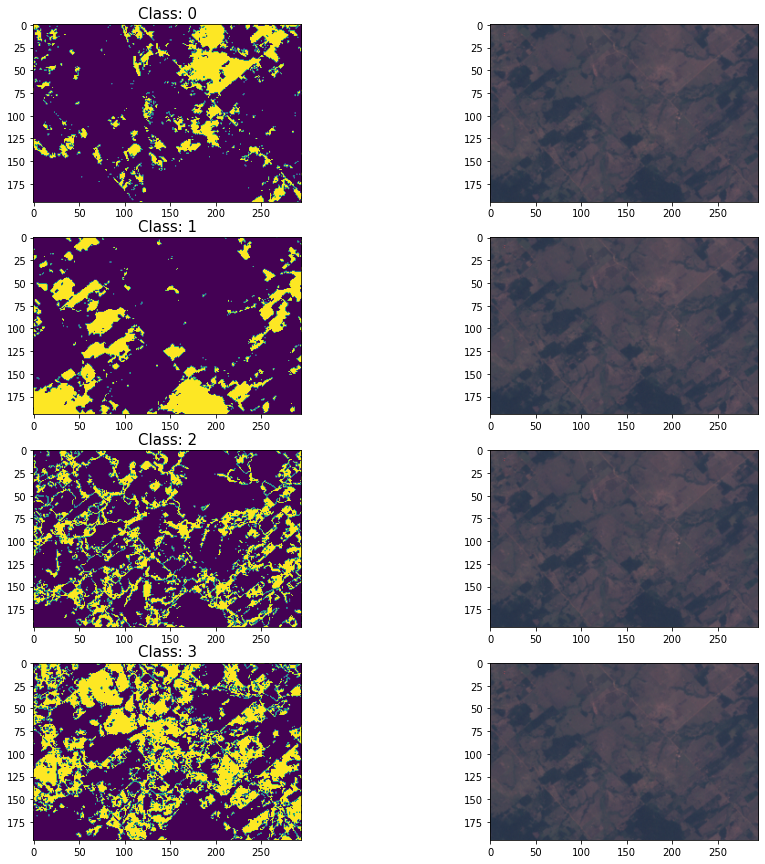

In [534]:
ROI = ee.Geometry.Rectangle(vec)
band_arrs = result.sampleRectangle(region=ROI)
data = np.array(band_arrs.get('cluster').getInfo())

f, axarr = plt.subplots(K_classes,2)
f.set_figheight(15)
f.set_figwidth(15)

for k in range(K_classes):
    axarr[k,0].imshow((data==k))
    axarr[k,0].set_title('Class: '+str(k),size=15)
    
    rgb_img_normed = convert_image_to_numpy(image,roi=vec,input_bands=bands,normalized=False)
    
    axarr[k,1].imshow(rgb_img_normed)

In [558]:
time_series =  []
ts_dates = []
labels = np.array(range(0,K_classes)).reshape(-1,1)
indx_mapping = np.zeros(collectionSize)

count = 0

for i in range(0,collectionSize):
    image = ee.Image(collectionList.get(i))
    #data= convert_image_to_numpy(image,roi=vec,input_bands=['B4','B3','B2'],normalized=True)
    
    try:
        ts = count_pixels_per_class(image,K=K_classes,classifier=kmeans,vec=vec)
        time_series.append(ts)
        ts_dates.append(collectionDates[i])
        indx_mapping[i] = count
        count+=1
    except Exception as e:
        print('Exception!: ',i)
        pass

ts_dates = np.array(ts_dates)
time_series = np.array(time_series)

Exception!:  7
Exception!:  8
Exception!:  9
Exception!:  10
Exception!:  11
Exception!:  12
Exception!:  13
Exception!:  16
Exception!:  17
Exception!:  24
Exception!:  27
Exception!:  33
Exception!:  34
Exception!:  35
Exception!:  36
Exception!:  37
Exception!:  38
Exception!:  39
Exception!:  40
Exception!:  47
Exception!:  48
Exception!:  51


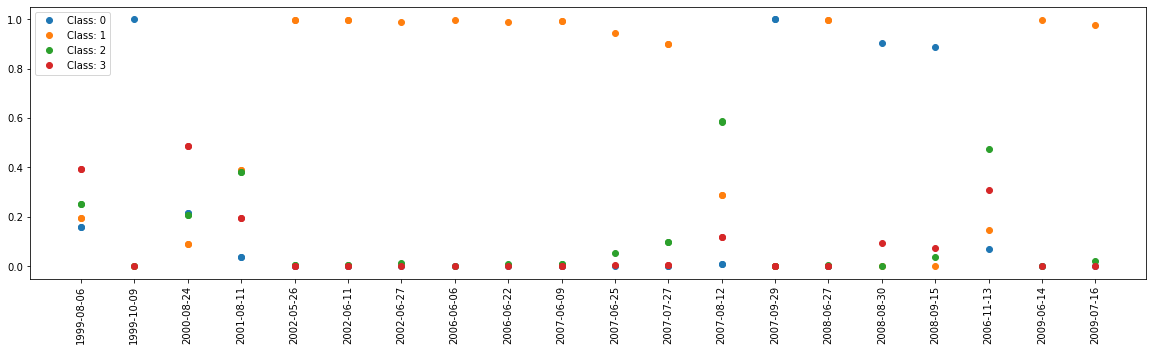

In [563]:
plt.figure(figsize=(20,5))

for k in range(K_classes):
    plt.plot(ts_dates, time_series[:,k],'o',label='Class: '+str(k))

plt.xticks(rotation='90')
plt.legend()
plt.show()

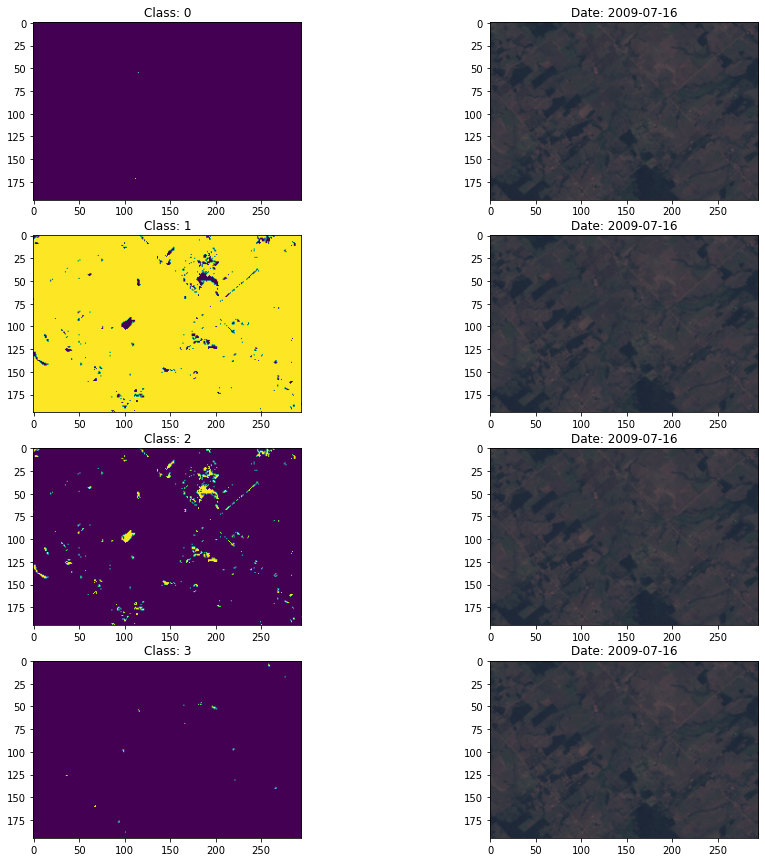

In [565]:
# Locate the specific time in the original data array
index = int(np.argmax(ts_dates=='2009-07-16'))

index_map = int(np.argmax(indx_mapping==index))

image = ee.Image(collectionList.get(index_map))

# Cluster the input using the trained clusterer.
result = image.cluster(kmeans)

ROI = ee.Geometry.Rectangle(vec)
band_arrs = result.sampleRectangle(region=ROI)
data = np.array(band_arrs.get('cluster').getInfo())

f, axarr = plt.subplots(K_classes,2)
f.set_figheight(15)
f.set_figwidth(15)

for k in range(K_classes):
    axarr[k,0].imshow((data==k))
    axarr[k,0].set_title('Class: '+str(k))
    
    rgb_img_normed = convert_image_to_numpy(image,roi=vec,input_bands=bands,normalized=False)
    
    axarr[k,1].imshow(rgb_img_normed)
    axarr[k,1].set_title('Date: '+ts_dates[index])